# Getting Started with `k-seq` package

This notebook is the interactive tutorial on core `k-seq` package usages. To see a static web version of the content in this notebook at [GitHub:k_seq/examples](https://github.com/ynshen/k-seq/tree/master/examples). For the details of the package, see [k-seq documentation](https://ynshen.github.io/k-seq/).


#### Example project: estimate the kinetic coefficients for ribozymes from post selection pool in self-aminoacylcation with BFO (Biotinyl-phenylalanine-oxazolone) ribozyme selection

This tutorial uses data from Evan Janzen's kinetic sequencing experiments on ribozymes that are selected to catalyze self-aminoacylation with BFO. In the experiment design, each unique sequence (unqiue type ribozyme) *s* follows the pseudo first-order reaction kinetics:

$$
F_{s, \text{Reacted}} = \frac{m_{s, t}}{m_{s, t_0}}= A(1-exp(-\alpha k c_{BFO} (t-t_0)))
$$
where
$$
\begin{align}
&t  \quad & \text{reaction time t} \\
&t_0 \quad & \text{initial time} \\
&c_{BFO} \quad & \text{initial concentration of BFO} \\
&m \quad & \text{amount of seq s, e.g. fmol} \\
&\alpha \quad & \text{parameter adjust for degradation of BFO} \\
&A \quad & \text{fraction of active RNA} \\
&k \quad & \text{kinetic coefficient} \\
\end{align}
$$

In this tutorial, we will use the python package `k-seq` to conduct step-by-step analysis and visualization from count file for each sample to final estimated kinetic coefficients. For examples of command line tool of pipelines see [GitHub:k_seq/examples/clt (to do)](https://github.com/ynshen/k-seq/tree/master/examples/clt)

### Requirements

To run this notebook, make sure:
  - `Python 3` is install (most python version works)
  - `k-seq` package and its dependencies are installed (See [Installation](https://github.com/ynshen/k-seq))
  - Count files from k-seq experiment is obtained

### Contents of this tutorial: 
  - Use `k_seq.data.SeqSampleSet` to parse count files and analyze k-seq data
  - Use `k_seq.data.SeqTable` to obtain and analyze a collection of "valid sequences"
  - Use `k_seq.data.SeqTable` to fit the kinetic model and estimate the kinetic coefficients with uncertainty estimation


## Initialize the workspace

We first setup the workspace by loading the necessary content from `k_seq` package, assign the path to count file, and path to working space for data or figure saving

In [2]:
%load_ext autoreload
%autoreload 2
from k_seq.data import SeqSampleSet, SeqTable, SeqFilter

# Set default screen dpi for jupyter notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# Set path to count files and current working space
from pathlib import Path

COUNT_FILES = '/mnt/storage/projects/k-seq/input/bfo_counts/counts'  # Directory to count files
WORKING_PATH = '/mnt/storage/projects/k-seq/working/bfo_evan/2019-6-28'
output_dir = Path(WORKING_PATH)
if not output_dir.exists():
    output_dir.mkdir(parents=True)

## `k-seq` sample analysis

In this section, we use `SeqSampleSet` to load a batch of count files from given path (folder storing count files) and analyze the data based on each sequencing samples.

### load sample count files
We can create a `SeqSampleSet` object and named it as `sample_set` by linking the object to multiple count files autmatically scan and extracted. We can use
```ipython
>?SeqSampleSet()```
To list the docstring for the class to see the usage details, here are the common parameters:

| Parameter | Note |
|:-----|:-----|
|`file_root`| Path to the folder containing the count files|
|`count_file_pattern`| Optional. Only files strictly contain the pattern will be considered as count files, useful when there are other file formats under the same folder|
|`name_pattern`| Optional. A built-in function to automatically extract infomation about the sample from its file name and assign the info as a metadata for the sample. Use `[]` to define the region used as sample name and use `{attribute name (,int/float)}` to define the attribute that is at the position and its data type|
|`x_values`| The 'x values' associate with the samples, for example, substrate concentration, time, etc. It can be assign with the attribution extracted using `name_pattern`|
|`sort_by`| Recommended. Always keep the samples in known order|
|`load_data`| Default False. If load the data while creating the sample_set object, useful for large files|
|`silent` | Limit extra printings if True|

In [3]:
sample_set = SeqSampleSet(
    file_root=COUNT_FILES,
    count_file_pattern='_counts.txt',
    x_values='bfo',
    name_pattern='R4[{exp_rep}-{bfo, float}{seq_rep}_S{id, int}]_counts.txt',
    sort_by = 'id',
    load_data=True,
    silent=True
)

NOTICE: no sample list is given, samples are collected from root folder:
	R4A-0A_S7_counts.txt
	R4B-250A_S17_counts.txt
	R4B-250B_S24_counts.txt
	R4A-50A_S4_counts.txt
	R4B-2A_S20_counts.txt
	R4A-10B_S12_counts.txt
	R4B-inputA_S15_counts.txt
	R4A-inputA_S1_counts.txt
	R4A-250A_S3_counts.txt
	R4B-inputB_S22_counts.txt
	R4A-250B_S10_counts.txt
	R4B-50B_S25_counts.txt
	R4B-0A_S21_counts.txt
	R4A-50B_S11_counts.txt
	R4A-2A_S6_counts.txt
	R4B-10A_S19_counts.txt
	R4B-2B_S27_counts.txt
	R4A-inputB_S8_counts.txt
	R4A-10A_S5_counts.txt
	R4B-0B_S28_counts.txt
	R4B-1250B_S23_counts.txt
	R4B-50A_S18_counts.txt
	R4B-10B_S26_counts.txt
	R4B-1250A_S16_counts.txt
	R4A-2B_S13_counts.txt
	R4A-1250B_S9_counts.txt
	R4A-1250A_S2_counts.txt
	R4A-0B_S14_counts.txt
Samples imported from /mnt/storage/projects/k-seq/input/bfo_counts/counts


### Calculate quantification factors
As different sequencing sample has different amount of DNA and sequencing depth, raw count number can not reflect a sequence's absolute abundance. Here, in this experiment, we use a method of spike in that adding a non-reactive RNA `AAAACAAAACAAAACAAA` with known amount to normalize each sample.

We define the quantification factor as the effective DNA amount to sequence, which can be calucalted as
$$
q_i = \frac{\text{Spike in amount (mol)}}{\text{Spike in counts}} \times \text{Total counts *N*}
$$

Thus, the absolute amount of Seq *s* with count *n* is $\frac{n}{N} \times q_i$

Due to the synthsis and sequencing error, we will see the spike-in sequence not only as the exact spike-in sequence but also as some similar sequences. Surveying the sequence peak around the spike-in can help us assess the sequencing error and determine the cutoff distance to count a sequence as spike in.

We can use `get_quant_factors` methods of `SeqSampleSet` to survey spike-in and calculate quantification factors. `max_dist_to_survey` is the argument control the maximal distance to survey around spike in.

In [4]:
sample_set.survey_spike_in_peak(spike_in_seq='AAAAACAAAAACAAAAACAAA',
                                max_dist_to_survey=10,
                                silent=True)

After survey of the spike-in sequence, we can visualize the peak around the spike-in sequence to determine a maximal distance to count a sequence as spike-in. In `SeqSampleSet`, there is a class `SeqSampleSet.visualizer` wrapping the visualizations functions from `k_seq.data.visualizer`. Here, show an example of programmable (customizable) plotting based on our visualizers to quickly create a bit more complex figures. We use `matplotlib.pyplot` to create a master figure with two sub-axes, and in each axis, we plot a `spike_in_peak_plot` with different configurations. Some core arguments of `spike_in_peak_plot`:

| Parameter | Note |
|:-----|:-----|
|`accumulate`| the counts will be accumulated counts from center to current distance if True|
|`max_dist`| maximal distance to plot|
|`norm_on_center`| if the abundance is normalized on the center |
|`log_y`| if the y-axis is on log scale|

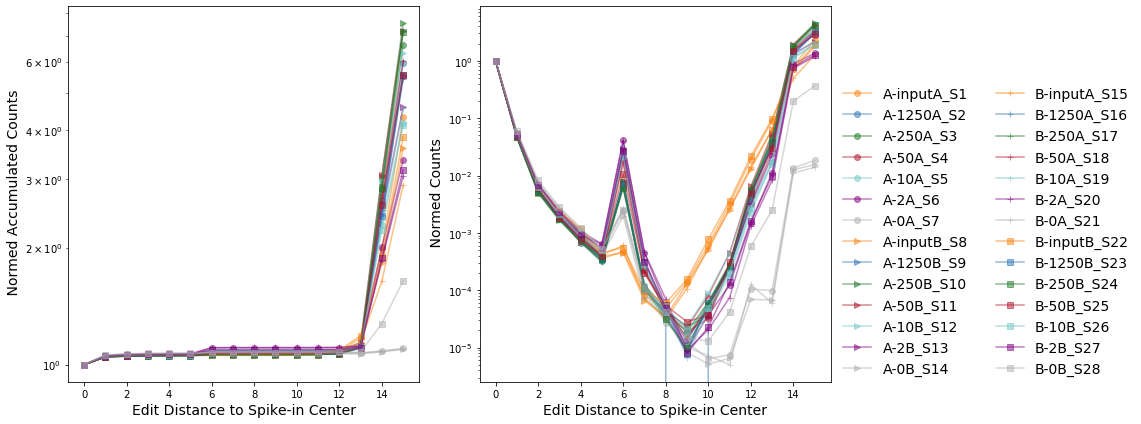

In [13]:
import numpy as np

# Manual marker/color list for each reps
marker_list = np.repeat(['-o', '->', '-+', '-s'], 7)
color_list = np.tile(['#FC820D', '#2C73B4', '#1C7725', '#B2112A', '#70C7C7', '#810080', '#AEAEAE'], reps=4).reshape([28])

# create a master figure side by side
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=[16, 6])
# add left figure as accumulated
sample_set.visualizer.spike_in_peak_plot(accumulate=True,
                                         max_dist=15, norm_on_center=True,
                                         color_list=color_list, marker_list=marker_list,
                                         legend_off=True,  ax=axes[0])
# add right figure as average peak shape, with legend
sample_set.visualizer.spike_in_peak_plot(max_dist=15, norm_on_center=True,log_y=True,
                                         color_list=color_list, marker_list=marker_list,
                                         legend_off=False,  ax=axes[1])
plt.show()

From the plots, we can see that by setting the maximal edit distance to count as a spike-in as 2, the error can be in general controlled within 1%. Thus, we set `max_dist=2`

In [31]:
# amount of spike-in DNA in unit fmol. We can also use a dictionary to avoid order difference
import numpy as np
spike_in_amounts = np.array([[4130, 1240, 826, 413, 207, 82.6, 41.3]])
spike_in_amounts = np.repeat(spike_in_amounts, repeats=4, axis=0).reshape(28)

sample_set.get_quant_factors(from_spike_in_amounts=spike_in_amounts, max_dist=2)

### Sample overview
We can use `SeqSampleSet.sample_overview` to get a `pd.DataFrame` object as a summary for each sample. As it is a `pd.DataFrame` object, it can be directly saved as `.csv` files by using `SeqSampleSet.sample_overview.to_csv(args)`.

Another useful visualizer of total counts, number of unique sequences, fraction of spike-in sequences is `SeqSampleSet.visualizer.count_file_info_plot()`. See examples as follows:

In [30]:
sample_set.sample_overview

,sample type,name,total counts,unique sequences,x_value,spike-in amount,spike-in counts (dist=2),spike-in percent,quantification factor
0,input,A-inputA_S1,2165970,330565,NaN,0.004130,416438,0.192264,0.021481
1,reacted,A-1250A_S2,2006578,29455,1250.0,0.001240,322730,0.160836,0.007710
2,reacted,A-250A_S3,1845900,23911,250.0,0.000826,267257,0.144784,0.005705
3,reacted,A-50A_S4,2617260,43687,50.0,0.000413,453121,0.173128,0.002386
4,reacted,A-10A_S5,1515552,26410,10.0,0.000207,351337,0.231821,0.000893
5,reacted,A-2A_S6,1580503,24362,2.0,0.000083,460933,0.291637,0.000283
6,reacted,A-0A_S7,2948173,2825,0.0,0.000041,2839946,0.963290,0.000043
7,input,A-inputB_S8,1257100,174225,NaN,0.004130,304332,0.242091,0.017060
8,reacted,A-1250B_S9,3451114,42691,1250.0,0.001240,601219,0.174210,0.007118
9,reacted,A-250B_S10,10273787,120423,250.0,0.000826,1312643,0.127766,0.006465


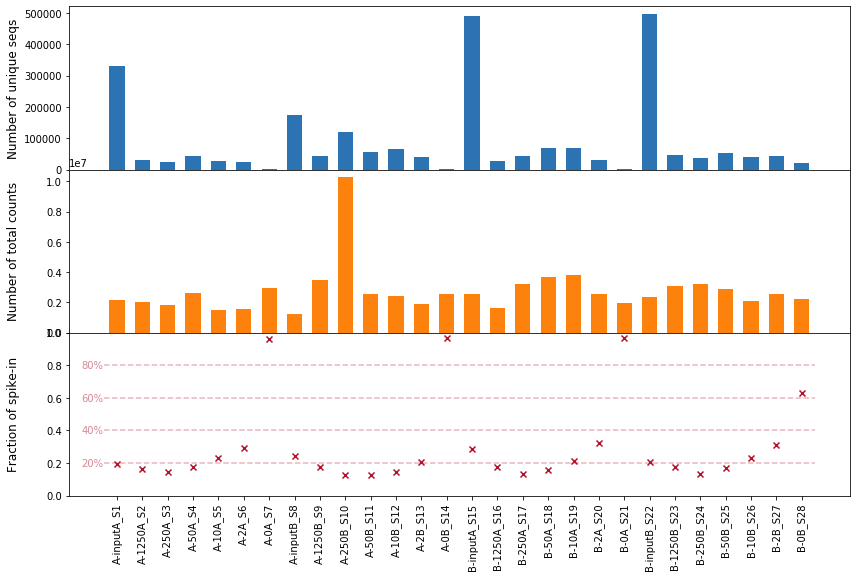

In [40]:
sample_set.visualizer.count_file_info_plot(plot_total_counts=True,
                                           plot_unique_seq=True,
                                           plot_spike_in_frac=True,
                                           sep_plot=True)

We can see that for samples `A-0A_S7`, `A-0B_S14`, `B-0A_S21`, and `B-0B_S29` (negative standards), most of reads belong to spike-in sequences, and minimal passing of RNA was observed. Here we choose to exclude these samples in further analysis.

### Replicates repeatability at sample level
In this experiment, we have four replicates for each of BFO concentration (2 sequencing reps for each of 2 experimental reps). We have a visualizer to examine the repeatablity of replicates in terms of its spike-in fractions and entropy efficiency (a measure of population distribution)

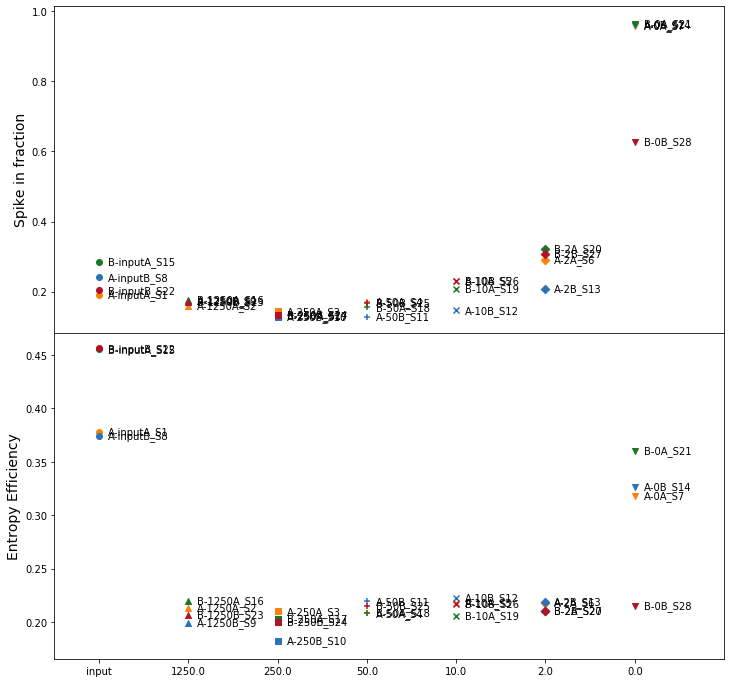

In [45]:
sample_set.visualizer.rep_spike_in_plot(group_by='bfo')

###  Distribution of sequences length and sequence populations
There are some built-in functions to visualize other properties of sequences in each sample, e.g. sequence length and population hetrogeneity

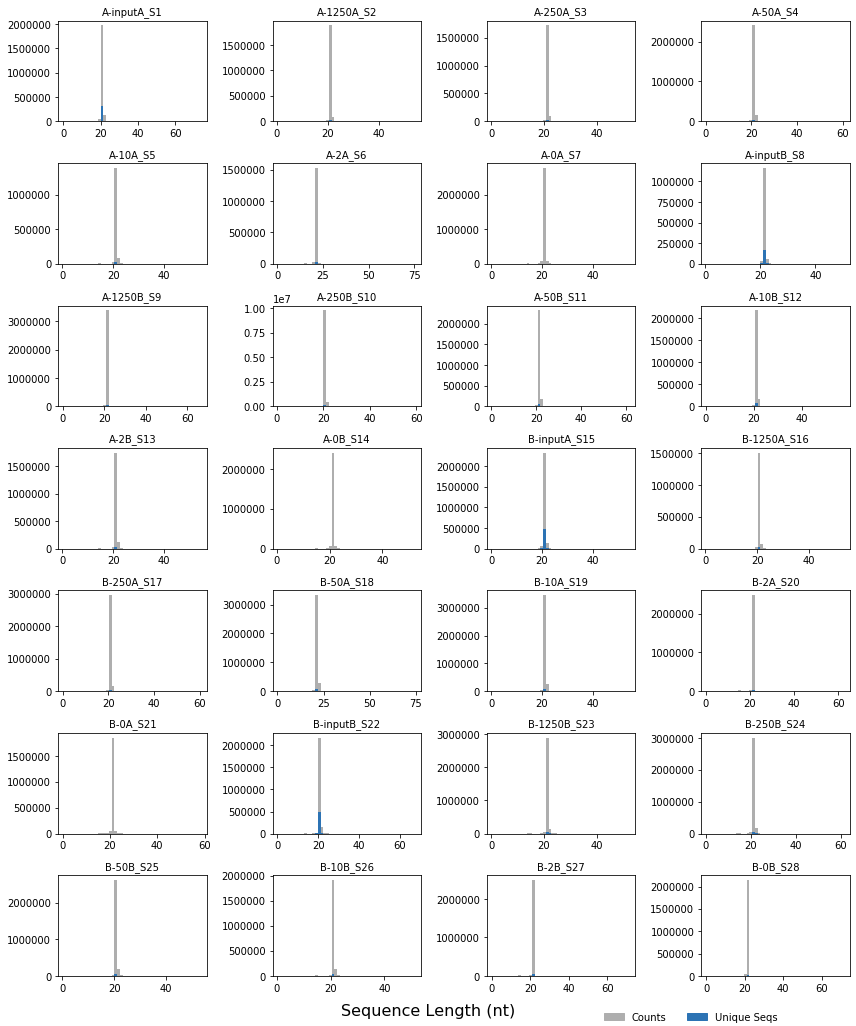

In [46]:
sample_set.visualizer.length_dist_plot_all(y_log=False)

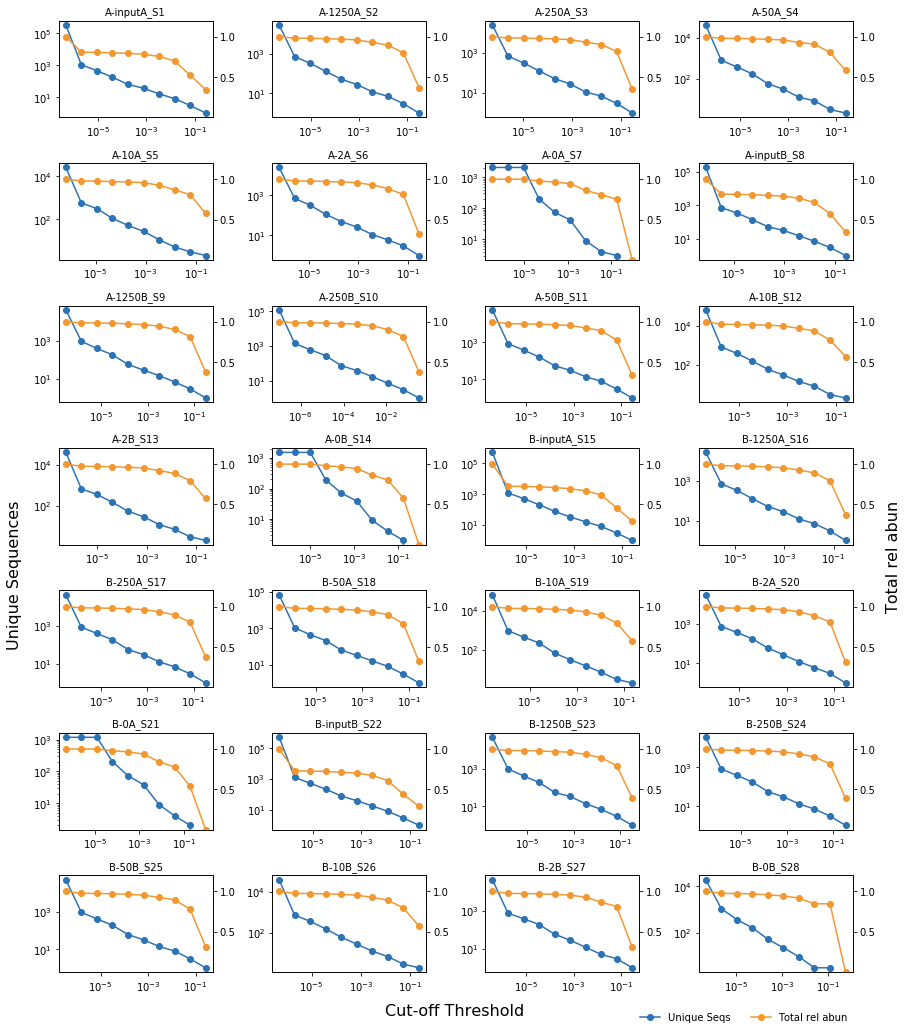

In [47]:
sample_set.visualizer.sample_count_cut_off_plot_all()

## Valid sequences analysis
In this section, we will pool and extract valid sequences from all the k-seq samples we have in `sample_set`, which can be further used for per sequence kinetic fitting. Extract valid seuqence (which has been detected in at least one input sample and one reacted sample) and convert to a `SeqTable` object can be easily done by using `SeqSampleSet.to_SeqTable()` function, and we can choose to remove the spike in the table.

There are some core attributes and methods in `SeqTable`:
| Attributes | Note |
|:-----|:-----|
|`x_values`| x values corresponding to each sample |
|`metadata`| some metadata related to the dataset |
|`count_table_react`/`count_table_input`| `pd.DataFrame` of count table for input samples and reacted samples|

| Methods | Note |
|:-----|:-----|
|`get_reacted_frac` | method to convert the `count_table_reacted` to a table of reacted fraction|
|`visualizer` | multiple visualization tools |

In [6]:
seq_table = sample_set.to_SeqTable(remove_spike_in=True)

We choose to calculate the reacted fraction of all samples except the 0 BFO concentration samples. As we have multiple input samples, choose to use the median of input sequences amount as the initial sequence for the calculation of reacted fraction

In [7]:
zero_samples = [sample_name for sample_name in seq_table.sample_info.keys() if '-0' in sample_name]
seq_table.get_reacted_frac(inplace=True, input_average='median', black_list=zero_samples)

### Valid sequence characterization
#### Sequence diversity and distribution
We can next analyze the valid sequences of their diversity and distribution. Here we use `visualizer.seq_occurrence_plot()` to show the number of unique sequences and total counts with respect to number of times detected in samples:

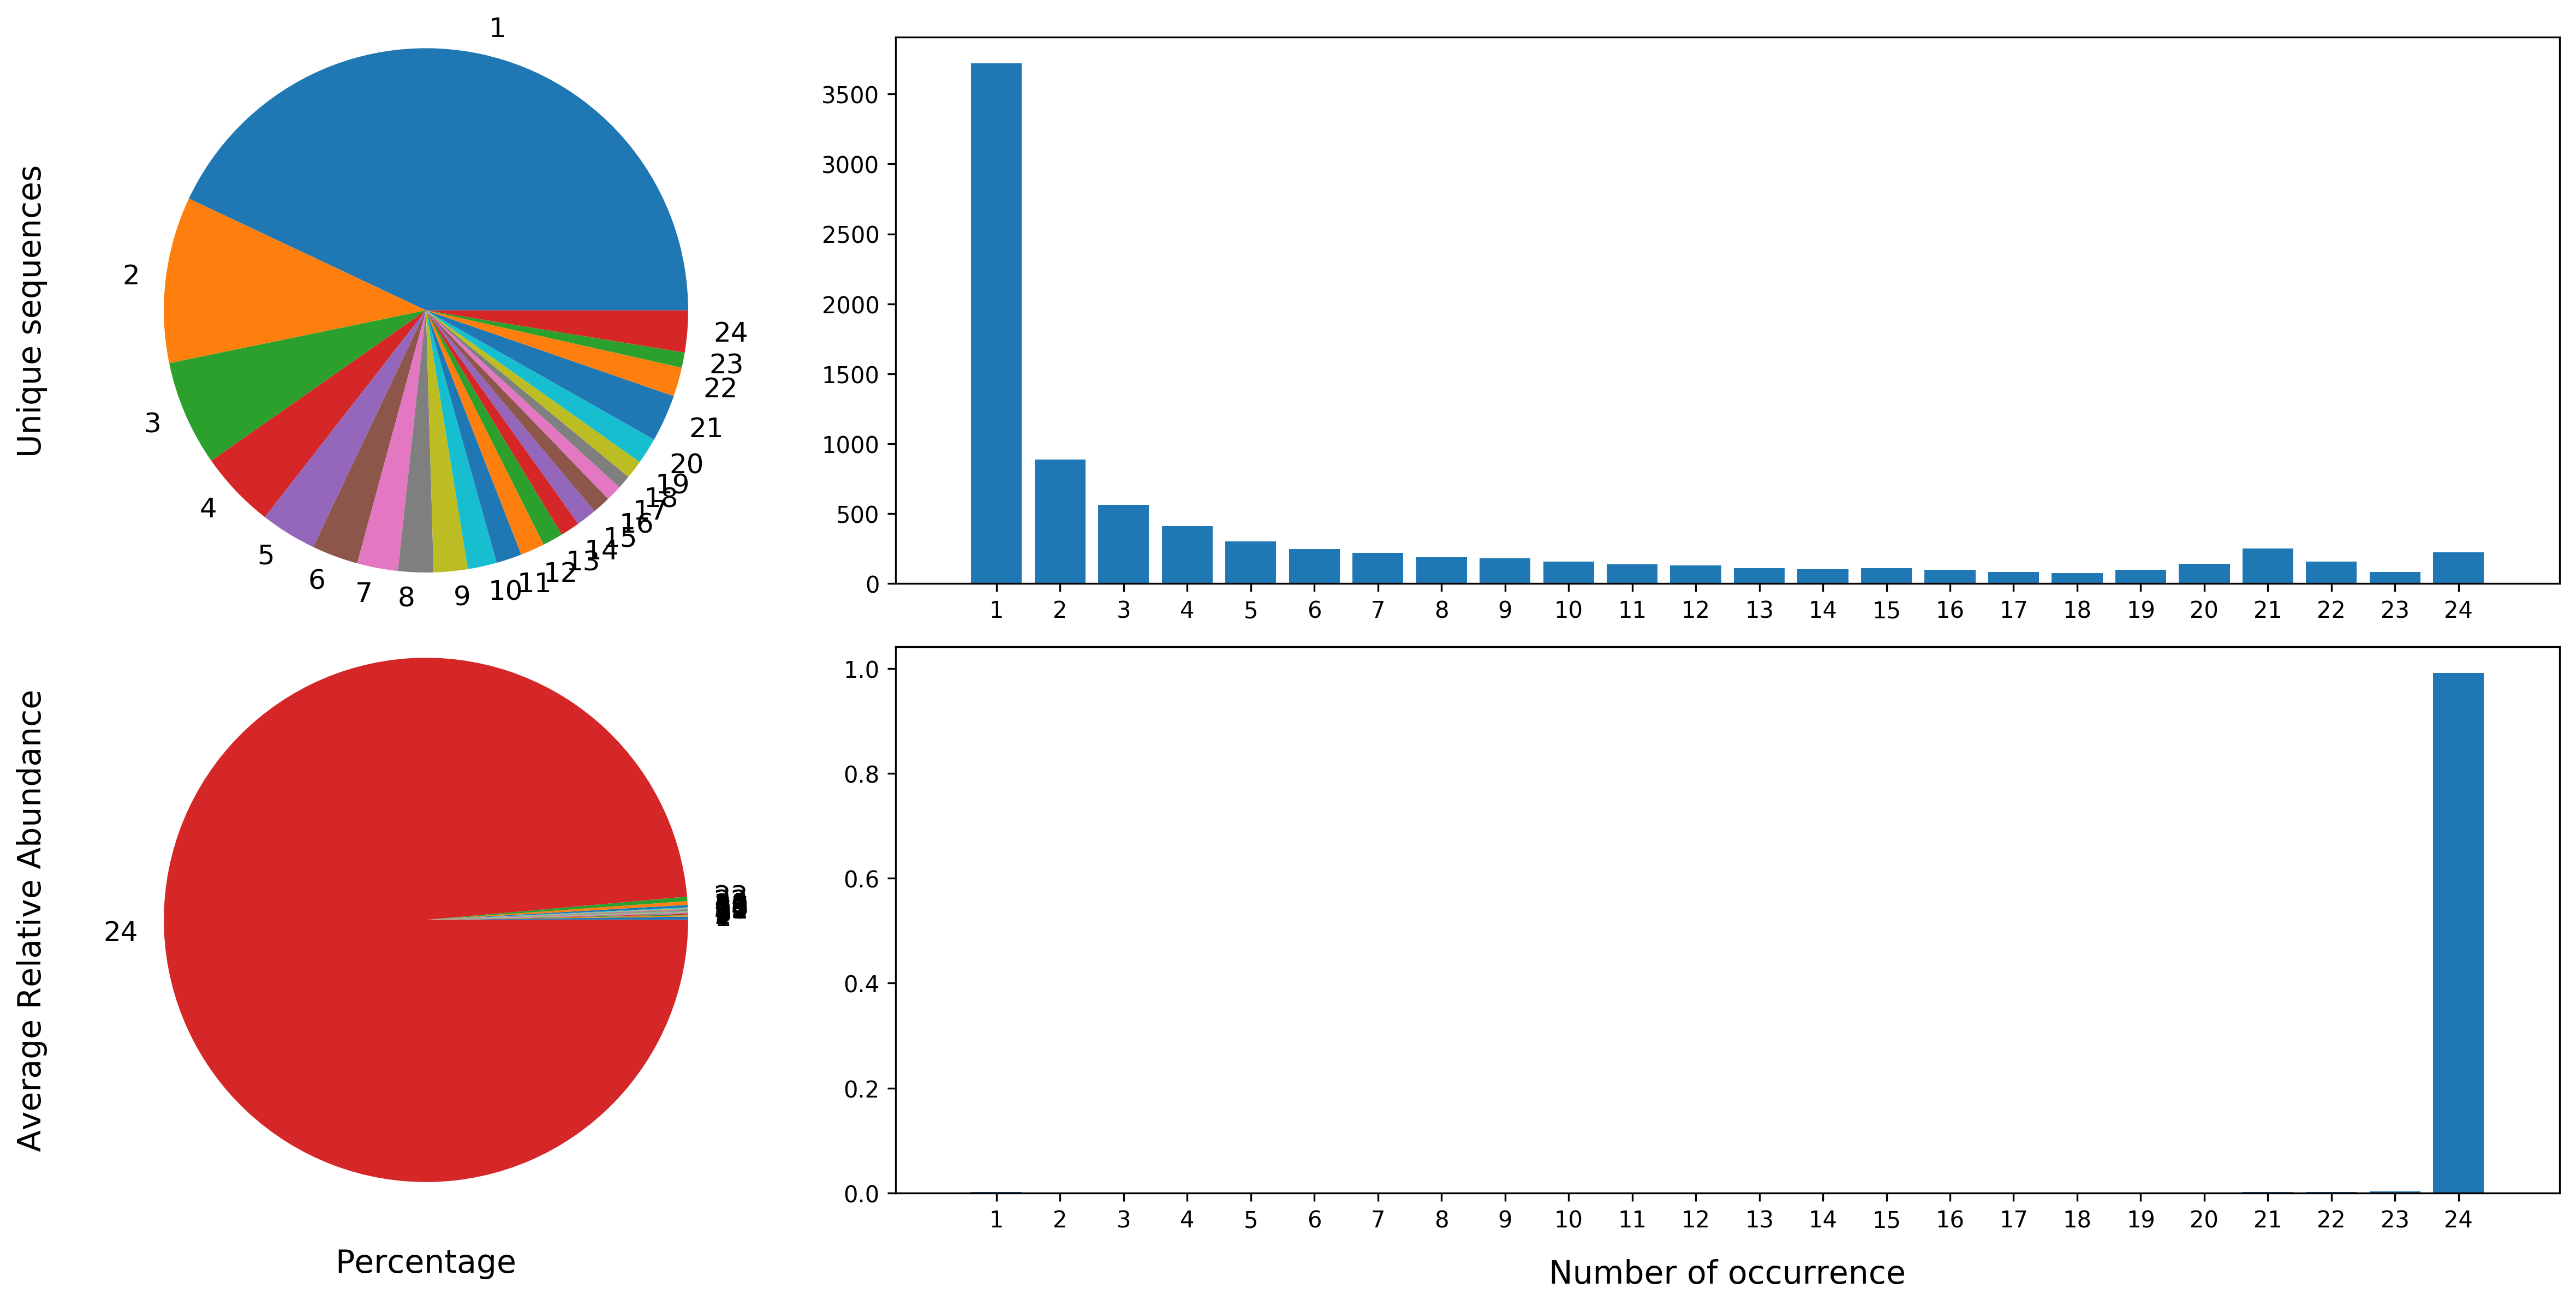

In [1009]:
seq_table.visualizer.seq_occurrence_plot()

Here we can see that this dataset is obviously heterogenous that most of unique sequences detected are only detected in limited number of samples while a smaller number of unique sequences are very abundant and has been detected in all the samples, including the sample with zero concentration BFO.
#### Measure variability across replicates

The variablity among replicates of experiments can be further evaluated by the reacted value of valid sequences across different replicates. The built-in method `visualizer.rep_variablity_plot` can draw violin plots indicating the standard deviation (`var_method='SD'`) or median absolute deviation (`var_method='MAD'`), with original value or at percent on mean (PSD) or median (PMAD): 

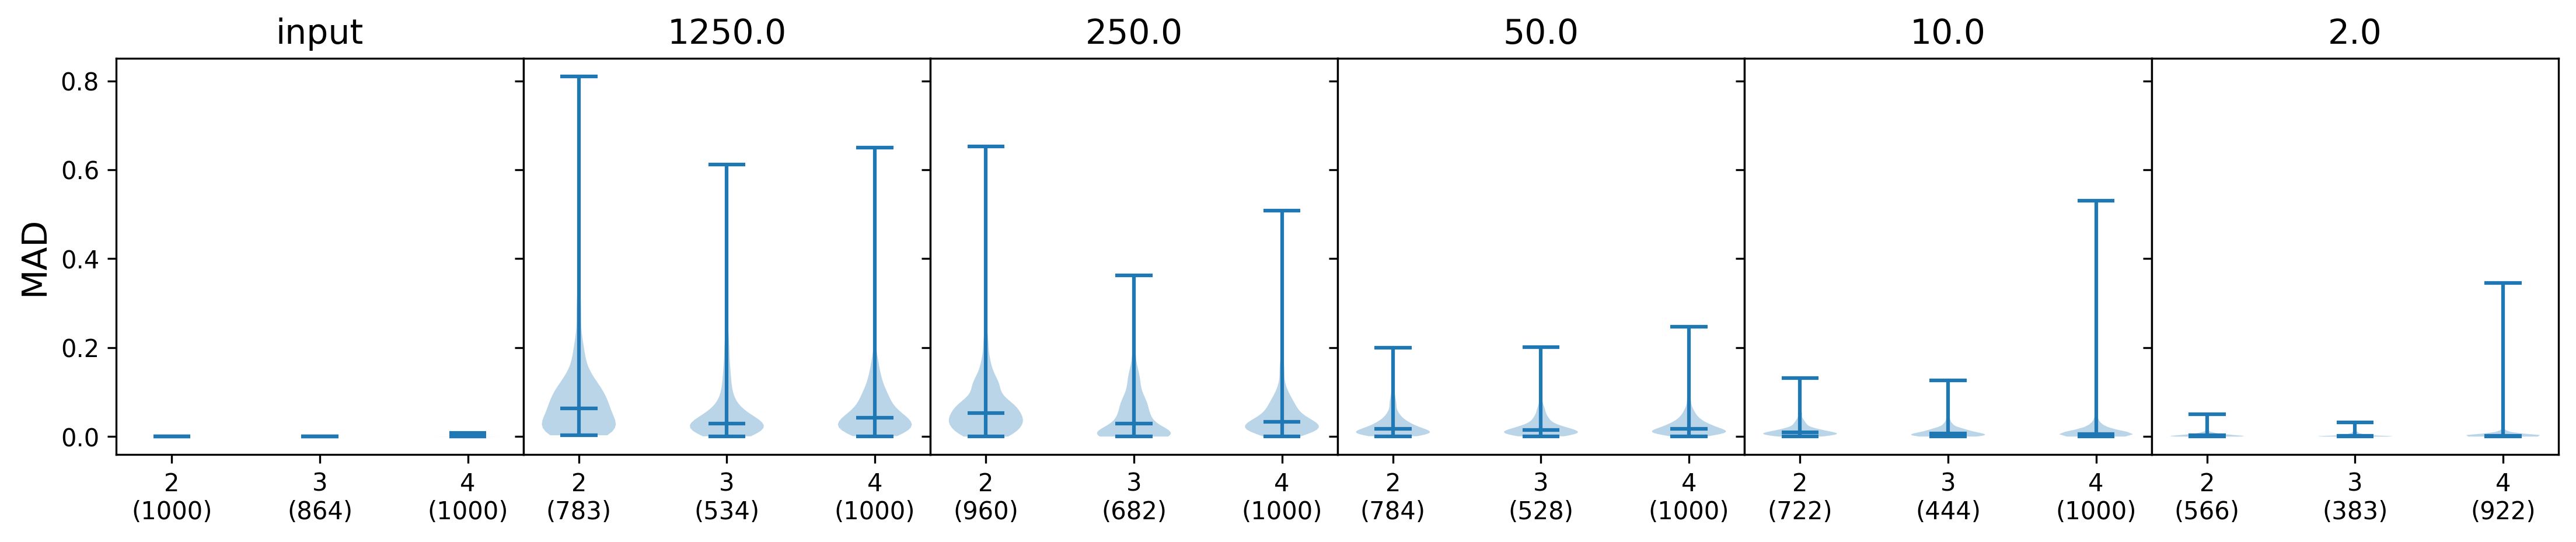

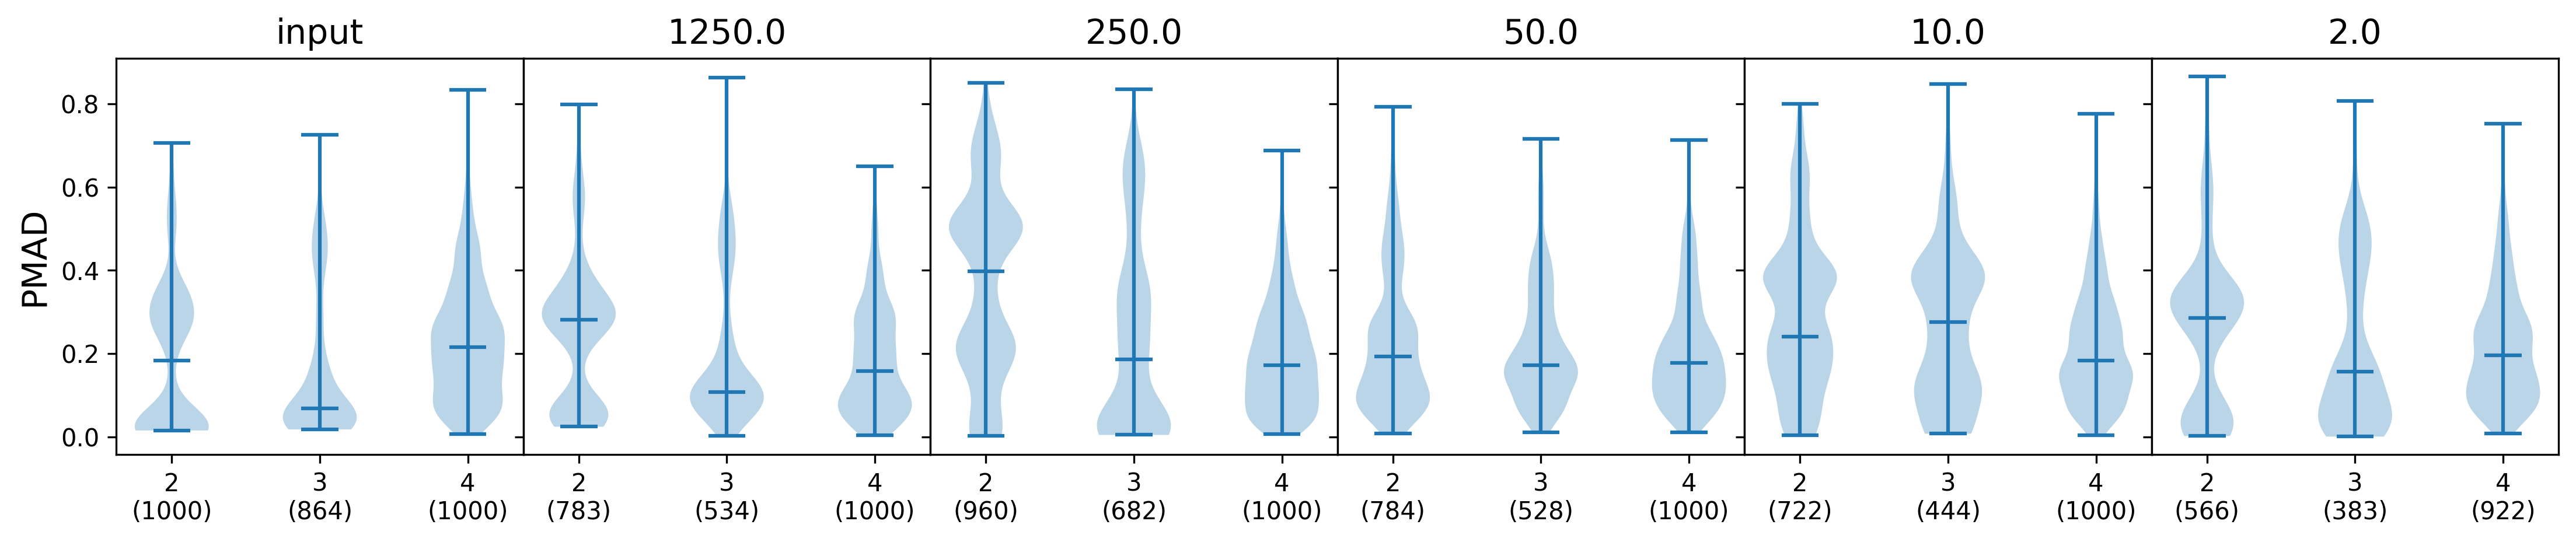

In [1011]:
seq_table.visualizer.rep_variability_plot(group_by='bfo', percentage=False)
seq_table.visualizer.rep_variability_plot(group_by='bfo', percentage=True)

We can see that, with different initial concentration of BFO, the variability varies; however, the percent variability is similar across different BFO concentration. This gives us the sense of exisitance of heteroscedasticity in fitting.
## Fit the sequences to kinetic model
After we calculated the reacted fraction for each sequence, we can fit data into kinetic model in parallel. We first need to define the kinetic model as a function

In [32]:
def bfo_model(x, A, k):
    return A * (1 - np.exp(-0.3371 * 90 * k * x * 1e-6))

Then, we can use `add_fitting` function to add a fitter to our table. Core arguments for this functions

| Arguments | Note |
|:-----|:-----|
|`bounds`| a 2 by k list indicate the lower bound and higher bound for parameters to estimate|
|`weights`| for weighted fitting, all data are weighted same if it is None|
|`metrics`| a list of callables (function) indicate extra metrics to calculate from data, in this case, 'kA'|
|`bootstrap_depth`| assign a number of bootstraps to dataset to estimate the confidence interval, recommand 1000 or more|
|`bs_return_size` | to save memory, we can choose only return part of the bootstrap records, after calculating relavent statistics|
|`missing_data_as_zero`| treat missing data as 0 if True|
|`random_init`|if randomly draw a number from [0, 1] as initial value for each parameter|
|`resample_pct_res`| there are two approaches to perform bootstrap: 1) bootstrap percent residues (from previous violin plots we conclude that percdent error are similarity distributed across data with different BFO concentration) or 2) bootstrap data point directly|
|`seq_to_fit`| pass a list of sequences and only fit those sequences|

In `k_seq` package, we also preset some commonly used filter in `SeqFilter` that can quick generate the list of sequences that pass the filter, for example, here we looked at sequences that:
  - detected in minimal 24 reacted samples
  - detected in minimal 4 input samples
  - minimal average relative abundance in input samples greater than 1%
  
And then only fit on these sequences 

In [42]:
def kA_fn(param):
    return param['k'] * param['A']

filters = SeqFilter(seq_table=seq_table, min_occur_reacted=24, min_occur_input=4, min_rel_abun_input=0.01)
filters.apply_filters()
seq_table.add_fitting(model=bfo_model,
                      bounds=[[0, 0], [1, np.inf]],
                      weights=None,
                      metrics={'kA': kA_fn},
                      bootstrap_depth=200,
                      bs_return_size=200,
                      missing_data_as_zero=False,
                      random_init=True,
                      resample_pct_res=False,
                      seq_to_fit=filters.seq_to_keep)

Then a `fitting` attribute is added to `seq_table` and we can check `fitting.config` to fitting configurations. (The fitting is not performed yet)

Before conduct actual fitting, we can use `SeqTable.save_as_dill()` and `SeqTable.load_from_dill()` to save and load data, configuration, and functions at hard drive to conduct parallel fitting on cluster server.

Here we will just run the fitting on the local machine with 6 parallel threads

In [43]:
seq_table.fitting.fitting(parallel_cores=6)

## Visualize the fitting results
### Single sequence results
There are some built-in function to visualize the fitting result for single sequence
  - `fitting_curve_plot`: show the fitting curve with data and bootstrapped curves
  - `bootstrap_params_dist_plot`: show the distribution of two estimated parameters and their correlation

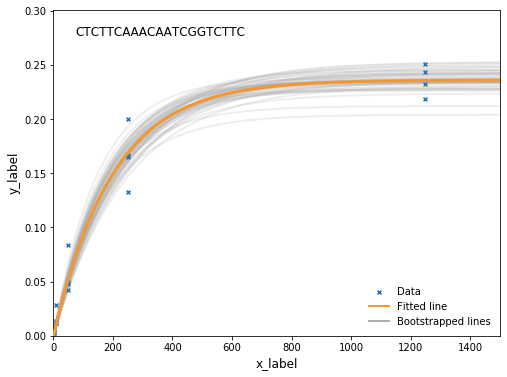

In [44]:
seq_table.fitting.visualizer.fitting_curve_plot(seq_ix=['CTCTTCAAACAATCGGTCTTC'])

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


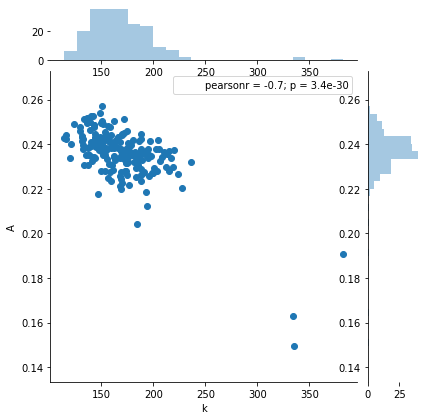

In [45]:
seq_table.fitting.visualizer.bootstrap_params_dist_plot(params_to_plot=['k', 'A'], seq_ix=['CTCTTCAAACAATCGGTCTTC'])

### All sequences results
We can show the fitting results for sequences using `fitting.summary` to return a `df.DataFrame` object, which can be further saved as `.csv` using `.to_csv()` method

In [40]:
seq_table.fitting.summary

,A_point_est,k_point_est,kA_point_est,A_mean,A_std,A_2.5,A_median,A_97.5,k_mean,k_std,k_2.5,k_median,k_97.5,kA_mean,kA_std,kA_2.5,kA_median,kA_97.5
CTCTTCAAACAATCGGTCTTC,0.236052,165.386232,39.039720,0.235701,0.011815,0.212657,0.237246,0.251351,168.579116,32.938176,123.721049,166.743608,223.489928,39.458586,5.797215,30.786389,38.971530,50.397497
CCACACTTCAAGCAATCGGTC,0.140131,277.722522,38.917565,0.139650,0.009200,0.120568,0.141253,0.153023,292.919409,83.059320,176.712397,277.066869,500.226230,40.302786,9.040099,26.265296,39.296391,60.705757
ACCCACTTCAAACAATCGGTC,0.203435,207.199326,42.151687,0.203673,0.016003,0.168918,0.202967,0.239031,219.533854,62.329118,141.415098,210.292199,368.095859,43.985614,9.452043,31.472603,42.927537,66.085833
CCGCTTCAAACAATCGGTTTG,0.471540,312.937193,147.562322,0.470079,0.036867,0.403135,0.473646,0.534286,321.340872,72.146995,191.900185,318.054021,453.251629,149.054975,25.745743,93.365382,148.801883,193.673831
ATTCACCTAGGTCATCGAGTGT,0.416950,542.638441,226.253006,0.416844,0.010700,0.396379,0.416742,0.436115,552.118955,66.959350,431.625532,546.777537,707.607330,229.828594,25.852821,185.908576,227.834102,290.477151
ATTACCCTGGTCATCGAGTGT,1.000000,404.836926,404.836926,0.997755,0.005523,0.978665,1.000000,1.000000,412.540401,33.100813,361.256461,408.779645,490.248217,411.584658,32.686758,359.297150,408.692856,490.171210
CTACTTCAAACAATCGGTCTG,0.498193,264.077118,131.561334,0.499020,0.011561,0.477144,0.499080,0.519871,264.468386,28.539579,215.729852,260.460842,324.468799,131.821886,12.997788,109.389124,130.057152,161.377738
CACACTTCAAGCAATCGGTC,0.110547,292.540645,32.339520,0.111657,0.008871,0.093616,0.112071,0.125952,300.480994,92.845298,164.615496,286.304874,512.269630,32.966212,8.397737,19.926049,31.927276,50.535988
ATTACCCTGGTCATCGAGTGA,0.897218,354.569393,318.126027,0.895628,0.027472,0.840204,0.900448,0.942822,361.876921,46.103495,291.348216,357.000858,462.387550,323.222030,34.705990,266.685072,318.434124,401.878968
ATTCACCTAGGTCATCGGGTGT,0.298714,794.942275,237.460002,0.298744,0.011136,0.275917,0.299711,0.317083,815.041323,128.544128,614.517868,798.928682,1069.952883,242.772975,33.809142,188.196417,239.763774,306.786715


We can also show one estimated parameter as a line plot with shade indicating 95% confidence intervals using `fitting.visualizer.param_value_plot`:

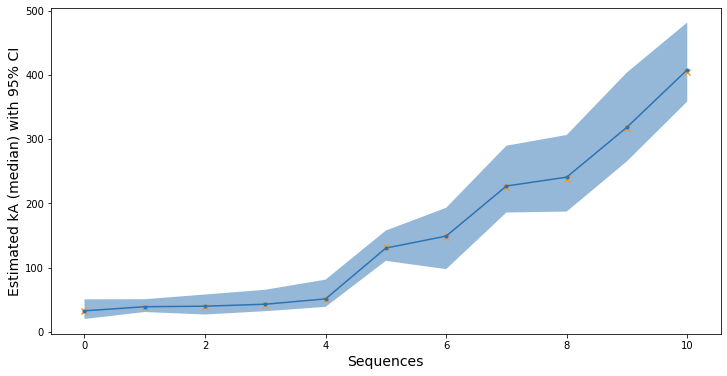

In [48]:
seq_table.fitting.visualizer.param_value_plot(param='kA', show_point_est=True)

### Summary
Here concludes the core components of `k-seq` package for kinetic sequencing experiment analysis. For detail usage and other functions, please refer to [k-seq documentation](https://ynshen.github.io/k-seq/).